In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from traitlets import traitlets
from IPython.display import display
from ipywidgets import HBox, VBox, BoundedFloatText, BoundedIntText, Text, Layout, Button

# Processing demographic data

We have retrieved demographic data from the data portal of the **National Centre for Statistics & Information** of the *Sultanate of Oman* (https://data.gov.om/)

Data are formatted in a two-columns file, where<br>
*  The __first__ column contains _years_.<br>
*  The __second__ column, which must be named *Population*, contains integer numbers and reports the total population in the Muscat region per year [2010-2019]

In [2]:
demo_file = "./data/JNNP_2020/Epidemiology_Oman.txt"
df = pd.read_csv(demo_file, sep='\t', index_col=0)
print(df)

      Population
Year            
2010      407006
2011      418652
2012      435149
2013      451652
2014      470085
2015      487592
2016      512039
2017      528327
2018      543930


## Predicting Muscat population growth

The observed period of time starts in **2014** and ends in the year specified below.

In [3]:
style = {'description_width': 'initial'}

simulation_end_text = BoundedIntText(
    min=2015,
    max=2100,
    step=1,
    value=2050,
    description='Simulate from 2014 until:', style=style)

class GenerateTimeButton(Button):
    def __init__(self, value=None, *args, **kwargs):
        super(GenerateTimeButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))
        
# Generate time period (list of years) to be simulated
def on_generate_time_button_clicked(button):
    button.value = np.arange(2014, simulation_end_text.value+1, 1).reshape((-1, 1))
    print("Simulation time points generated")

generate_time_button = GenerateTimeButton(
    description="Generate",
    button_style='info',
    tooltip='Generate simulation time points'
)
generate_time_button.value=np.array([])
generate_time_button.on_click(on_generate_time_button_clicked)

hbox_time = HBox([simulation_end_text, generate_time_button])
display(hbox_time)

Simulation time points generated


Linear regression analysis is conducted on demographic data using the *LinearRegression* module from the Python **sklearn** package. The typical linear regression equation: \begin{align}y & = mx + b\end{align} is fitted and *coefficient of determination ($r^2$)*, *intercept* ($b$) and *slope* ($m$) are inferred.

 
coefficient of determination: 0.996
intercept (b): -35324154.9
slope (m): [17774.017]

time:				[2010 2011 2012 2013 2014 2015 2016 2017 2018]
predicted response:		[401619. 419393. 437167. 454941. 472715. 490489. 508263. 526037. 543811.]
predicted response [2018]	543811.0
actual data [Dec. 2018]:	543930
predicted response [2019]	561585.0
actual data [Dec. 2019]:	567851
predicted response [2020]	579359.0
actual data [Feb. 2020]:	570196


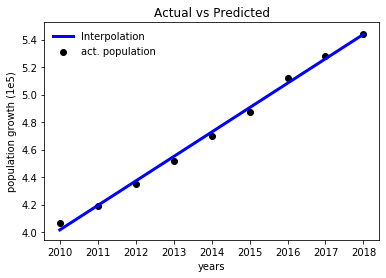

In [4]:
if not generate_time_button.value.any():
    simulation_end_text.value=2050
    generate_time_button.click()

x_new = generate_time_button.value

#######################################

%matplotlib inline
x = df.index.values.reshape((-1, 1))
y = df.Population
model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(" ")
print('coefficient of determination:', np.round(r_sq, 3))
print('intercept (b):', np.round(model.intercept_, 3))
print('slope (m):', np.round(model.coef_, 3))
print('')

# Predict response of known data
y_pred = model.predict(x)
print('time:', np.transpose(x)[0], sep='\t\t\t\t')
print('predicted response:', np.around(y_pred), sep='\t\t')

# Plot outputs
axis_scale = 1e5
plt.scatter(x, y/axis_scale,  color='black', label="act. population")
plt.plot(x, y_pred/axis_scale, color='blue',
         linewidth=3, label="Interpolation")

plt.title('Actual vs Predicted')
plt.xlabel('years')
plt.ylabel('population growth (1e5)')

plt.legend(loc='upper left', frameon=False)
plt.savefig('linear_regression.svg', format='svg', dpi=600)

# Predict response of future data [2018-2020]
y_pred = np.round(model.predict(x_new))
print('predicted response [2018]', y_pred[4], sep='\t')
print('actual data [Dec. 2018]:\t{}'.format(df.iloc[8]['Population']))

print('predicted response [2019]', y_pred[5], sep='\t')
print('actual data [Dec. 2019]:\t{}'.format(567851))

print('predicted response [2020]', y_pred[6], sep='\t')
print('actual data [Feb. 2020]:\t{}'.format(570196))

### Theoretical response with plateau and inflection point at 2030, 2040 and 2050

Population growth was simulated considering a plateau in 2030, 2040 and in 2050 through the exponential function: $y = Y_M-(Y_M-Y_0)\cdot(e^{-ax})$, where $Y_M$ is the maximum at which the plateau ends up, $Y_0$ is the starting population and $a$ is a rate constant that governs how fast it gets there. Here, $Y_0 = 5.44 \cdot 1e5$ (actual population in 2018), while $Y_M$ is equals to $7.57$, $9.35$ and $11.13$ per $100000$ individuals, as inferred by linear regression respectively for 2030, 2040 and 2050.

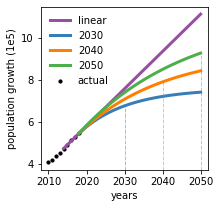

In [5]:
import math 

axis_scale = 1e5
y_pred = model.predict(x_new)/axis_scale

fig = plt.figure(figsize=(3,3))

# Plot outputs
plt.scatter(x, y/axis_scale,  color='black', label="actual", s=10)
plt.plot(x_new, y_pred, color='#984ea3', linewidth=3, label="linear")

def plateau(x, M, M0, a):
    return M - (M-M0)*math.exp(-a*x)
y_pl = np.vectorize(plateau)

M_2018 = y_pred[np.where(x_new==2018)[0][0]]
M_2030 = y_pred[np.where(x_new==2030)[0][0]]
M_2040 = y_pred[np.where(x_new==2040)[0][0]]
M_2050 = y_pred[np.where(x_new==2050)[0][0]]

y_2030= y_pl(x=np.arange(0,33), M=M_2030, M0=M_2018, a=.08)
y_2040= y_pl(x=np.arange(0,33), M=M_2040, M0=M_2018, a=.045)
y_2050= y_pl(x=np.arange(0,33), M=M_2050, M0=M_2018, a=.035)

plt.plot(x_new[4:], y_2030, color='#377eb8',
         linewidth=3, label="2030")
plt.plot(x_new[4:], y_2040, color='#ff7f00',
         linewidth=3, label="2040")
plt.plot(x_new[4:], y_2050, color='#4daf4a',
         linewidth=3, label="2050")

plt.axvline(x=2030, linewidth=.5, linestyle='dashdot', color="#377eb8", ymax=.40)
plt.axvline(x=2040, linewidth=.5, linestyle='dashdot', color="#ff7f00", ymax=.55)
plt.axvline(x=2050, linewidth=.5, linestyle='dashdot', color="#4daf4a", ymax=.72)

plt.xlabel('years')
plt.ylabel('population growth (1e5)')
plt.legend(loc='upper left', frameon=False)
plt.rcParams.update({'font.size': 11})

plt.savefig('fitted_vs_predicted.svg', format='svg', dpi=1200)

# Markov Chain design

A **discrete-time Markov chain (DTMC)** is designed to model the *death* event of HD patients and *onset* of the disease among inhabitants of Muscat. To do that, *birth/death* events were inferred from observational data collected from 2013 to 2019 in the Muscat population.

## Set the transition rates

The modeled process is stochastic and *memoryless*, in that it allows to make predictions based solely on its present state. The process passes through three states: **Healthy**, **HD Alive** and **HD Dead** as a result of *birth* and *death* events, driven in turn by: <b>I</b> = incidence rate of the disease and <b>D</b> = death rate because of the disease.<br/>
<img src="data/JNNP_2020/MC_states.png" align="middle" width="300">

where:<br/>
* $I_{avg}$: &emsp;the average HD incidence rate in the world population (min=**0.38** per 100,000 per year, [https://doi.org/10.1002/mds.25075]; max=**0.9** per 100,000 per year, [https://doi.org/10.1186/s12883-019-1556-3])
* $I_{Muscat}$: the actual HD incidence rate in Muscat (**0.56** per 100,000 per year [2013-2019])
* $D_{avg}$: &emsp;the HD death rate (min=**1.55** per million population registered in England-Wales in 1960-1973, [https://pubmed.ncbi.nlm.nih.gov/6233902/]; max=**2.27** per million population registered in USA in 1971-1978, [https://doi.org/10.1212/wnl.38.5.769])
* $D_{Muscat}$: the actual HD death rate in Muscat (**1.82** per million population [2013-2019])

In [6]:
# estimated incidence rate world-wide 
## min = 0.38/year per 100,000 [https://doi.org/10.1002/mds.25075]
## max = 0.9/year per 100,000  [https://doi.org/10.1186/s12883-019-1556-3]
est_inc_rates = [0.38, 0.56, 0.7, 0.9]

# actual incidence rate (0.56 per 100,000 per year) ~ 3 new HD patients in Muscat in 2018 [https://data.gov.om/OMPOP2016/population?indicator=1000140&region=1000020-muscat&nationality=1000010-omani]
act_inc_rate = 0.56

# estimated death rate world-wide 
## min = 1.55 per million (England-Wales in 1960-1973, https://www.ncbi.nlm.nih.gov/pubmed/6233902)
## max = 2.27 per million (United States in 1971-1978, https://doi.org/10.1212/wnl.38.5.769)
est_death_rates = [1.55, 1.819, 2.27]

# actual death rate ~ 1 patient in 2018 per 100.000 per year in Muscat
act_death_rate = 1.819

# starting HD individuals in Muscat in 2018 (32)
hd_2018 = 32

### Set the number of simulation traces

In order to approximate the posterior distribution of the HD prevalence, one performs a *Monte Carlo* simulation with $1000$ independent simulation runs from where calculating the *average number of incident cases* per year.

In [7]:
simulation_traces = BoundedIntText(
    min=1,
    max=5000,
    step=1,
    value=1000,
    description='Simulation traces:', style=style)
display(simulation_traces)

BoundedIntText(value=1000, description='Simulation traces:', max=5000, min=1, style=DescriptionStyle(descripti…

### Initialize state vectors

For each simulation step, $6$ vectors are updated:<br/>
* ***est_inc*** stores the variation of incidence over time according to $I_{avg}$
* ***act_inc*** stores the variation of incidence over time according to $I_{Muscat}$
* ***est_death*** stores the numbers of deaths over time according to $D_{avg}$
* ***act_death*** stores the numbers of deaths over time according to $D_{Muscat}$
* ***est_alive_HD*** stores the number of alive HD patients over time, based on ***est_inc*** and ***est_death***
* ***act_alive_HD*** astores the number of alive HD patients over time, based on ***act_inc*** and ***act_death***

In [8]:
# record the number of simulation steps
sim_time = len(x_new[4:])

# get the number of simulation traces from the textfield above
num_traces = simulation_traces.value

# get number of possible Iavg and Davg
num_iavg = len(est_inc_rates)
num_davg = len(est_death_rates)

est_inc = np.zeros((num_iavg, num_davg, num_traces, sim_time), dtype=int)
act_inc = np.zeros((num_traces, sim_time), dtype=int)

est_death = np.zeros((num_iavg, num_davg, num_traces, sim_time), dtype=int)
act_death = np.zeros((num_traces, sim_time), dtype=int)

est_alive_HD = np.zeros((num_iavg, num_davg, num_traces, sim_time), dtype=int)
est_alive_HD[:, :, :, 0] = hd_2018
act_alive_HD = np.zeros((num_traces, sim_time), dtype=int)
act_alive_HD[:, 0] = hd_2018

### Trigger the Monte Carlo simulation

All possible estimates of $I_{avg}$ and $D_{avg}$ are shuffled here and, for each combination, 1000 independent simulations will be launched. For each simulation and for each time step, the number of alive HD patients will be calculated as the sum of the number of *currently alive* HD patients and that of *new* HD patients, from which the number of currently *deceased* patients is subtracted. This computation is performed for:

#### Linear estimate (regression)

In [9]:
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        print("Evaluating Iavg={} and Davg={}".format(iavg_value, davg_value))
        for rep in range(num_traces):
            for t in range(sim_time-1):
                curr_pop = y_pred[t]*100000  # <-------
                
                if(act_inc[rep, t] == 0):
                    act_inc[rep, t] = np.random.poisson((act_inc_rate * curr_pop)/100000)
                    act_death[rep, t] = np.random.poisson((act_death_rate * curr_pop)/1000000)
                    act_alive_HD[rep, t+1] = act_alive_HD[rep, t] - act_death[rep, t] + act_inc[rep, t]

                est_inc[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (iavg_value * curr_pop)/100000)
                
                est_death[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (davg_value * curr_pop)/1000000)
                
                est_alive_HD[iavg_idx, davg_idx, rep, t+1] = est_alive_HD[iavg_idx, davg_idx, rep, t] - \
                    est_death[iavg_idx, davg_idx, rep, t] + est_inc[iavg_idx, davg_idx, rep, t]
                

Evaluating Iavg=0.38 and Davg=1.55
Evaluating Iavg=0.38 and Davg=1.819
Evaluating Iavg=0.38 and Davg=2.27
Evaluating Iavg=0.56 and Davg=1.55
Evaluating Iavg=0.56 and Davg=1.819
Evaluating Iavg=0.56 and Davg=2.27
Evaluating Iavg=0.7 and Davg=1.55
Evaluating Iavg=0.7 and Davg=1.819
Evaluating Iavg=0.7 and Davg=2.27
Evaluating Iavg=0.9 and Davg=1.55
Evaluating Iavg=0.9 and Davg=1.819
Evaluating Iavg=0.9 and Davg=2.27


##### Plot HD population predicted to be alive

N.b., __est. HD population__ accounts for the population that is predicted to be alive every year according to *incidence* and *death* rates that are the world average; __act. HD population__ refers instead to the actual rates calculated stright on the actual Muscat population records, as previously described.

A ranom plot (i.e., a random trace among 1000) will be generaed for each combination of $I_{avg}$ and $D_{avg}$.

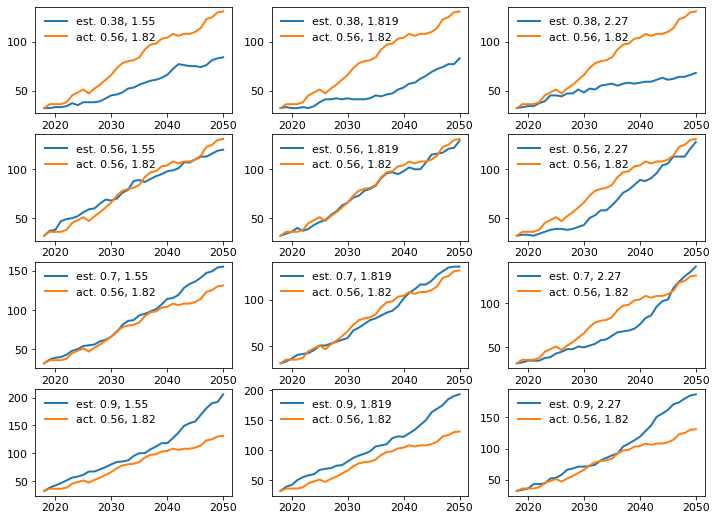

In [10]:
# Select a random trace
rtrace = np.random.randint(0,num_traces)

# Plot a random trace of est/act. alive HD cases in the Muscat region 
# for each combination of Iavg and Davg
fig, ax = plt.subplots(len(est_inc_rates), len(est_death_rates), figsize=(12, 9))
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        ax[iavg_idx, davg_idx].plot(x_new[4:], est_alive_HD[iavg_idx, davg_idx, rtrace, :], 
                                    lw=2, label='est. {}, {}'.format(iavg_value, davg_value))
        ax[iavg_idx, davg_idx].plot(x_new[4:], act_alive_HD[rtrace, :], 
                                    lw=2, label='act. {}, {}'.format(act_inc_rate, str(round(act_death_rate, 2))))
        ax[iavg_idx, davg_idx].legend(loc='upper left', frameon=False)


plt.savefig('alive_population.svg', format='svg', dpi=1200)

#### Inflation at 2030

In [11]:
# record the number of simulation steps
sim_time_2030 = len(y_2030)

# get the number of simulation traces from the textfield above
num_traces_2030 = simulation_traces.value

# get number of possible Iavg and Davg
num_iavg_2030 = len(est_inc_rates)
num_davg_2030 = len(est_death_rates)

est_inc_2030 = np.zeros((num_iavg_2030, num_davg_2030, num_traces_2030, sim_time_2030), dtype=int)
act_inc_2030 = np.zeros((num_traces_2030, sim_time_2030), dtype=int)

est_death_2030 = np.zeros((num_iavg_2030, num_davg_2030, num_traces_2030, sim_time_2030), dtype=int)
act_death_2030 = np.zeros((num_traces_2030, sim_time_2030), dtype=int)

est_alive_HD_2030 = np.zeros((num_iavg_2030, num_davg_2030, num_traces_2030, sim_time_2030), dtype=int)
est_alive_HD_2030[:, :, :, 0] = hd_2018
act_alive_HD_2030 = np.zeros((num_traces_2030, sim_time_2030), dtype=int)
act_alive_HD_2030[:, 0] = hd_2018

In [12]:
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        print("Evaluating Iavg={} and Davg={}".format(iavg_value, davg_value))
        for rep in range(num_traces_2030):
            for t in range(sim_time_2030-1):
                curr_pop = y_2030[t]*100000  # <-------
                
                if(act_inc_2030[rep, t] == 0):
                    act_inc_2030[rep, t] = np.random.poisson((act_inc_rate * curr_pop)/100000)
                    act_death_2030[rep, t] = np.random.poisson((act_death_rate * curr_pop)/1000000)
                    act_alive_HD_2030[rep, t+1] = act_alive_HD_2030[rep, t] - act_death_2030[rep, t] + act_inc_2030[rep, t]

                est_inc_2030[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (iavg_value * curr_pop)/100000)
                est_death_2030[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (davg_value * curr_pop)/1000000)
                est_alive_HD_2030[iavg_idx, davg_idx, rep, t+1] = est_alive_HD_2030[iavg_idx, davg_idx, rep, t] - \
                    est_death_2030[iavg_idx, davg_idx, rep, t] + est_inc_2030[iavg_idx, davg_idx, rep, t]

Evaluating Iavg=0.38 and Davg=1.55
Evaluating Iavg=0.38 and Davg=1.819
Evaluating Iavg=0.38 and Davg=2.27
Evaluating Iavg=0.56 and Davg=1.55
Evaluating Iavg=0.56 and Davg=1.819
Evaluating Iavg=0.56 and Davg=2.27
Evaluating Iavg=0.7 and Davg=1.55
Evaluating Iavg=0.7 and Davg=1.819
Evaluating Iavg=0.7 and Davg=2.27
Evaluating Iavg=0.9 and Davg=1.55
Evaluating Iavg=0.9 and Davg=1.819
Evaluating Iavg=0.9 and Davg=2.27


##### Plot HD population predicted to be alive

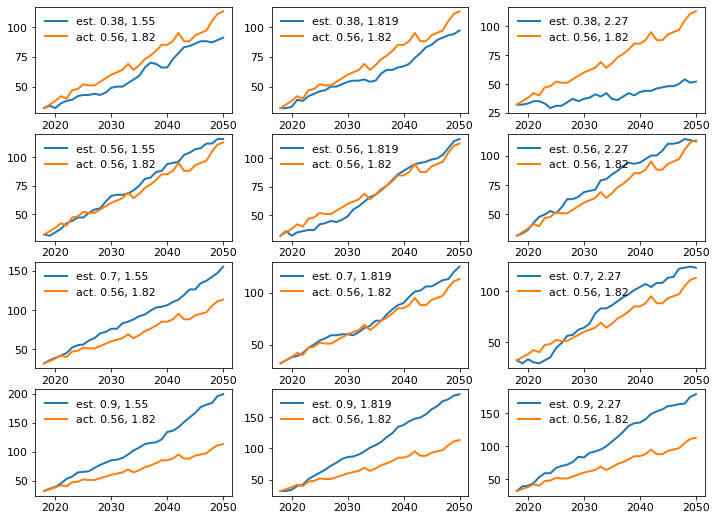

In [13]:
# Select a random trace
rtrace = np.random.randint(0,num_traces_2030)

# Plot a random trace of est/act. alive HD cases in the Muscat region 
# for each combination of Iavg and Davg
fig, ax = plt.subplots(len(est_inc_rates), len(est_death_rates), figsize=(12, 9))
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        ax[iavg_idx, davg_idx].plot(x_new[4:], est_alive_HD_2030[iavg_idx, davg_idx, rtrace, :], 
                                    lw=2, label='est. {}, {}'.format(iavg_value, davg_value))
        ax[iavg_idx, davg_idx].plot(x_new[4:], act_alive_HD_2030[rtrace, :], 
                                    lw=2, label='act. {}, {}'.format(act_inc_rate, str(round(act_death_rate, 2))))
        ax[iavg_idx, davg_idx].legend(loc='upper left', frameon=False)


plt.savefig('alive_population_y2030.svg', format='svg', dpi=1200)

#### Inflation at 2040

In [14]:
# record the number of simulation steps
sim_time_2040 = len(y_2040)

# get the number of simulation traces from the textfield above
num_traces_2040 = simulation_traces.value

# get number of possible Iavg and Davg
num_iavg_2040 = len(est_inc_rates)
num_davg_2040 = len(est_death_rates)

est_inc_2040 = np.zeros((num_iavg_2040, num_davg_2040, num_traces_2040, sim_time_2040), dtype=int)
act_inc_2040 = np.zeros((num_traces_2040, sim_time_2040), dtype=int)

est_death_2040 = np.zeros((num_iavg_2040, num_davg_2040, num_traces_2040, sim_time_2040), dtype=int)
act_death_2040 = np.zeros((num_traces_2040, sim_time_2040), dtype=int)

est_alive_HD_2040 = np.zeros((num_iavg_2040, num_davg_2040, num_traces_2040, sim_time_2040), dtype=int)
est_alive_HD_2040[:, :, :, 0] = hd_2018
act_alive_HD_2040 = np.zeros((num_traces_2040, sim_time_2040), dtype=int)
act_alive_HD_2040[:, 0] = hd_2018

In [15]:
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        print("Evaluating Iavg={} and Davg={}".format(iavg_value, davg_value))
        for rep in range(num_traces_2040):
            for t in range(sim_time_2040-1):
                curr_pop = y_2040[t]*100000  # <-------
                
                if(act_inc_2040[rep, t] == 0):
                    act_inc_2040[rep, t] = np.random.poisson((act_inc_rate * curr_pop)/100000)
                    act_death_2040[rep, t] = np.random.poisson((act_death_rate * curr_pop)/1000000)
                    act_alive_HD_2040[rep, t+1] = act_alive_HD_2040[rep, t] - act_death_2040[rep, t] + act_inc_2040[rep, t]

                est_inc_2040[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (iavg_value * curr_pop)/100000)
                est_death_2040[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (davg_value * curr_pop)/1000000)
                est_alive_HD_2040[iavg_idx, davg_idx, rep, t+1] = est_alive_HD_2040[iavg_idx, davg_idx, rep, t] - \
                    est_death_2040[iavg_idx, davg_idx, rep, t] + est_inc_2040[iavg_idx, davg_idx, rep, t]

Evaluating Iavg=0.38 and Davg=1.55
Evaluating Iavg=0.38 and Davg=1.819
Evaluating Iavg=0.38 and Davg=2.27
Evaluating Iavg=0.56 and Davg=1.55
Evaluating Iavg=0.56 and Davg=1.819
Evaluating Iavg=0.56 and Davg=2.27
Evaluating Iavg=0.7 and Davg=1.55
Evaluating Iavg=0.7 and Davg=1.819
Evaluating Iavg=0.7 and Davg=2.27
Evaluating Iavg=0.9 and Davg=1.55
Evaluating Iavg=0.9 and Davg=1.819
Evaluating Iavg=0.9 and Davg=2.27


##### Plot HD population predicted to be alive

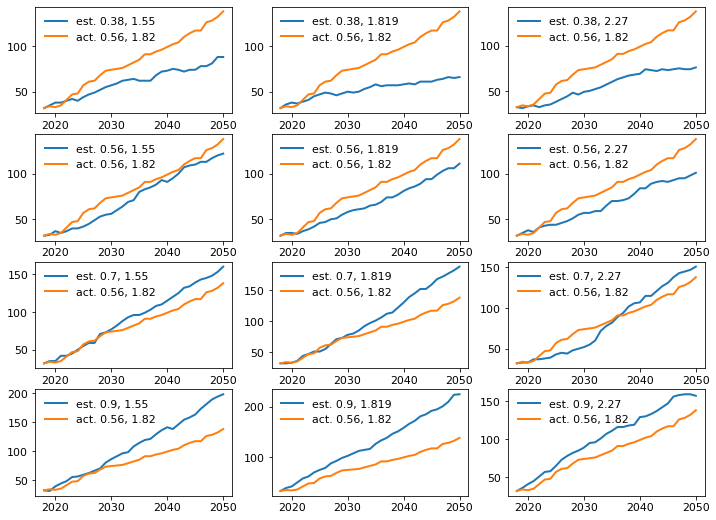

In [16]:
# Select a random trace
rtrace = np.random.randint(0,num_traces_2040)

# Plot a random trace of est/act. alive HD cases in the Muscat region 
# for each combination of Iavg and Davg
fig, ax = plt.subplots(len(est_inc_rates), len(est_death_rates), figsize=(12, 9))
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        ax[iavg_idx, davg_idx].plot(x_new[4:], est_alive_HD_2040[iavg_idx, davg_idx, rtrace, :], 
                                    lw=2, label='est. {}, {}'.format(iavg_value, davg_value))
        ax[iavg_idx, davg_idx].plot(x_new[4:], act_alive_HD_2040[rtrace, :], 
                                    lw=2, label='act. {}, {}'.format(act_inc_rate, str(round(act_death_rate, 2))))
        ax[iavg_idx, davg_idx].legend(loc='upper left', frameon=False)


plt.savefig('alive_population_y2040.svg', format='svg', dpi=1200)

#### Inflation at 2050

In [17]:
# record the number of simulation steps
sim_time_2050 = len(y_2050)

# get the number of simulation traces from the textfield above
num_traces_2050 = simulation_traces.value

# get number of possible Iavg and Davg
num_iavg_2050 = len(est_inc_rates)
num_davg_2050 = len(est_death_rates)

est_inc_2050 = np.zeros((num_iavg_2050, num_davg_2050, num_traces_2050, sim_time_2050), dtype=int)
act_inc_2050 = np.zeros((num_traces_2050, sim_time_2050), dtype=int)

est_death_2050 = np.zeros((num_iavg_2050, num_davg_2050, num_traces_2050, sim_time_2050), dtype=int)
act_death_2050 = np.zeros((num_traces_2050, sim_time_2050), dtype=int)

est_alive_HD_2050 = np.zeros((num_iavg_2050, num_davg_2050, num_traces_2050, sim_time_2050), dtype=int)
est_alive_HD_2050[:, :, :, 0] = hd_2018
act_alive_HD_2050 = np.zeros((num_traces_2050, sim_time_2050), dtype=int)
act_alive_HD_2050[:, 0] = hd_2018

In [18]:
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        print("Evaluating Iavg={} and Davg={}".format(iavg_value, davg_value))
        for rep in range(num_traces_2050):
            for t in range(sim_time_2050-1):
                curr_pop = y_2050[t]*100000  # <-------
                
                if(act_inc_2050[rep, t] == 0):
                    act_inc_2050[rep, t] = np.random.poisson((act_inc_rate * curr_pop)/100000)
                    act_death_2050[rep, t] = np.random.poisson((act_death_rate * curr_pop)/1000000)
                    act_alive_HD_2050[rep, t+1] = act_alive_HD_2050[rep, t] - act_death_2050[rep, t] + act_inc_2050[rep, t]

                est_inc_2050[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (iavg_value * curr_pop)/100000)
                est_death_2050[iavg_idx, davg_idx, rep, t] = np.random.poisson(
                    (davg_value * curr_pop)/1000000)
                est_alive_HD_2050[iavg_idx, davg_idx, rep, t+1] = est_alive_HD_2050[iavg_idx, davg_idx, rep, t] - \
                    est_death_2050[iavg_idx, davg_idx, rep, t] + est_inc_2050[iavg_idx, davg_idx, rep, t]

Evaluating Iavg=0.38 and Davg=1.55
Evaluating Iavg=0.38 and Davg=1.819
Evaluating Iavg=0.38 and Davg=2.27
Evaluating Iavg=0.56 and Davg=1.55
Evaluating Iavg=0.56 and Davg=1.819
Evaluating Iavg=0.56 and Davg=2.27
Evaluating Iavg=0.7 and Davg=1.55
Evaluating Iavg=0.7 and Davg=1.819
Evaluating Iavg=0.7 and Davg=2.27
Evaluating Iavg=0.9 and Davg=1.55
Evaluating Iavg=0.9 and Davg=1.819
Evaluating Iavg=0.9 and Davg=2.27


##### Plot HD population predicted to be alive

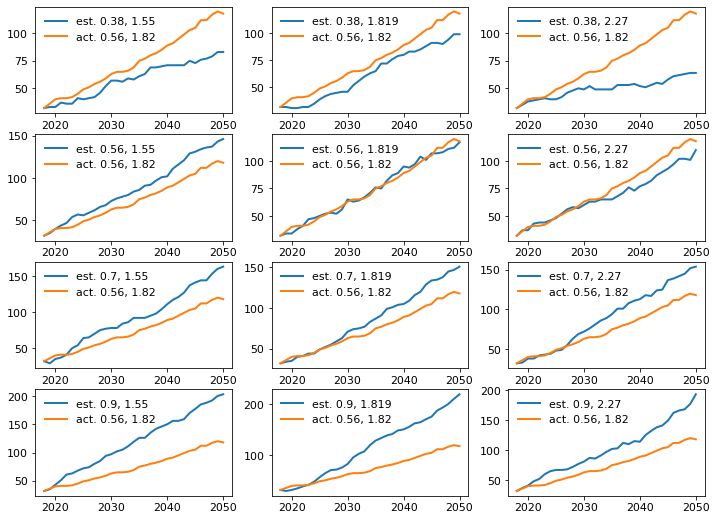

In [19]:
# Select a random trace
rtrace = np.random.randint(0,num_traces_2050)

# Plot a random trace of est/act. alive HD cases in the Muscat region 
# for each combination of Iavg and Davg
fig, ax = plt.subplots(len(est_inc_rates), len(est_death_rates), figsize=(12, 9))
for iavg_idx, iavg_value in enumerate(est_inc_rates):
    for davg_idx, davg_value in enumerate(est_death_rates):
        ax[iavg_idx, davg_idx].plot(x_new[4:], est_alive_HD_2050[iavg_idx, davg_idx, rtrace, :], 
                                    lw=2, label='est. {}, {}'.format(iavg_value, davg_value))
        ax[iavg_idx, davg_idx].plot(x_new[4:], act_alive_HD_2050[rtrace, :], 
                                    lw=2, label='act. {}, {}'.format(act_inc_rate, str(round(act_death_rate, 2))))
        ax[iavg_idx, davg_idx].legend(loc='upper left', frameon=False)


plt.savefig('alive_population_y2050.svg', format='svg', dpi=1200)

# Calculate average estimates of prevalence over traces

The **prevalence** of HD is calculated year by year until the end of simulation and for each simulation trace.

In [20]:
# act_alive_HD_mu = np.around(np.mean(act_alive_HD, axis=0) / y_pred, 2)
# act_alive_HD_sigma = np.around(np.std(act_alive_HD, axis=0) / y_pred, 2)
# act_alive_HD_2030_mu = np.around(np.mean(act_alive_HD_2030 / y_2030, axis=0), 2)
# act_alive_HD_2030_sigma = np.around(np.std(act_alive_HD_2030 / y_2030, axis=0), 2)
# act_alive_HD_2040_mu = np.around(np.mean(act_alive_HD_2040 / y_2040, axis=0), 2)
# act_alive_HD_2040_sigma = np.around(np.std(act_alive_HD_2040 / y_2040, axis=0), 2)
# act_alive_HD_2050_mu = np.around(np.mean(act_alive_HD_2050 / y_2050, axis=0), 2)
# act_alive_HD_2050_sigma = np.around(np.std(act_alive_HD_2050 / y_2050, axis=0), 2)

# Iavg = [0.38, 0.56, 0.7, 0.9]
# Davg = [1.55, 1.819, 2.27]
# Select simulations with Iavg=0.56 (index=1) and Davg=2.27 (index=2) estimates
est_alive_HD_mu = np.around(np.mean(est_alive_HD[1,2,:,:], axis=0) / y_pred[4:], 2)
est_alive_HD_sigma = np.around(np.std(est_alive_HD[1,2,:,:], axis=0) / y_pred[4:], 2)
est_alive_HD_2030_mu = np.around(np.mean(est_alive_HD_2030[1,2,:,:]/ y_2030, axis=0), 2)
est_alive_HD_2030_sigma = np.around(np.std(est_alive_HD_2030[1,2,:,:]/ y_2030, axis=0), 2)
est_alive_HD_2040_mu = np.around(np.mean(est_alive_HD_2040[1,2,:,:]/ y_2040, axis=0), 2)
est_alive_HD_2040_sigma = np.around(np.std(est_alive_HD_2040[1,2,:,:]/ y_2040, axis=0), 2)
est_alive_HD_2050_mu = np.around(np.mean(est_alive_HD_2050[1,2,:,:]/ y_2050, axis=0), 2)
est_alive_HD_2050_sigma = np.around(np.std(est_alive_HD_2050[1,2,:,:]/ y_2050, axis=0), 2)

print("Linear regression (est.): {}".format(est_alive_HD_mu))
# print("Linear regression (act.): {}\n".format(act_alive_HD_mu))
print("flection at 2030 (est.): {}".format(est_alive_HD_2030_mu))
# print("flection at 2030 (act.): {}\n".format(act_alive_HD_2030_mu))
print("flection at 2040 (est.): {}".format(est_alive_HD_2040_mu))
# print("flection at 2040 (act.): {}\n".format(act_alive_HD_2040_mu))
print("flection at 2050 (est.): {}".format(est_alive_HD_2050_mu))
# print("flection at 2050 (act.): {}".format(act_alive_HD_2050_mu))

Linear regression (est.): [ 5.88  5.96  6.05  6.14  6.25  6.37  6.49  6.62  6.73  6.87  7.    7.12
  7.23  7.35  7.51  7.64  7.77  7.9   8.04  8.18  8.32  8.45  8.58  8.72
  8.87  9.01  9.14  9.28  9.43  9.59  9.74  9.89 10.04]
flection at 2030 (est.): [ 5.88  6.02  6.17  6.35  6.54  6.74  6.95  7.16  7.38  7.62  7.85  8.08
  8.33  8.59  8.86  9.12  9.39  9.67  9.92 10.2  10.48 10.75 11.05 11.32
 11.62 11.91 12.2  12.5  12.81 13.1  13.41 13.7  14.01]
flection at 2040 (est.): [ 5.88  6.03  6.16  6.32  6.51  6.69  6.87  7.05  7.25  7.44  7.64  7.85
  8.09  8.3   8.52  8.73  8.97  9.21  9.44  9.68  9.92 10.17 10.41 10.64
 10.89 11.14 11.39 11.65 11.9  12.17 12.43 12.69 12.96]
flection at 2050 (est.): [ 5.88  5.99  6.13  6.26  6.39  6.54  6.69  6.86  7.02  7.2   7.38  7.59
  7.77  7.94  8.13  8.36  8.58  8.8   9.    9.22  9.43  9.66  9.9  10.13
 10.37 10.59 10.81 11.05 11.28 11.52 11.77 12.01 12.25]


### Plot prevalence estimates

Calculate the **average prevalence** values ($\mu$) for each year and over all simulation traces, together with the **standard deviation** ($\sigma$) values.<br/>
Make a line plot with bands, with *years* on the X-axis and the *prevalence* values on the Y-axis.

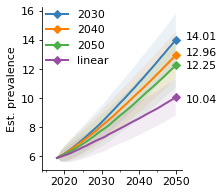

In [21]:
def plot_double_prevalence(splot_idx: int, ax, x_vector: list, y1_vector_mu: list, y1_vector_sigma:
                           list, y2_vector_mu: list, y2_vector_sigma: list,
                           enable_y_axis_label: bool = False):

    markers_on = [len(y1_vector_mu)-1]

    ax[splot_idx].fill_between(x_vector.flatten(), y1_vector_mu+y1_vector_sigma, y1_vector_mu-y1_vector_sigma,
                               facecolor='#377eb8', alpha=0.1)

    ax[splot_idx].fill_between(x_vector.flatten(), y2_vector_mu+y2_vector_sigma, y2_vector_mu-y2_vector_sigma,
                               facecolor='#ff7f00', alpha=0.1)

    ax[splot_idx].plot(x_vector, y1_vector_mu, '-gD', lw=2,
                       label=r'$I_{avg}=0.56$, $D_{avg}=1.82$', markevery=markers_on, color='#377eb8')
    ax[splot_idx].set_xticks([2014, 2015, 2025, 2035, 2045], minor=True)

    ax[splot_idx].plot(x_vector, y2_vector_mu, '-gD', lw=2,
                       label=r'$I_{avg}=0.56$, $D_{avg}=2.27$', markevery=markers_on, color="#ff7f00")
    if enable_y_axis_label:
        ax[splot_idx].set_ylabel('Est. prevalence')
    ax[splot_idx].set_xticks([2014, 2015, 2025, 2035, 2045], minor=True)

    ax[splot_idx].spines['top'].set_visible(False)
    ax[splot_idx].spines['right'].set_visible(False)
    ax[splot_idx].spines['bottom'].set_visible(True)
    ax[splot_idx].spines['left'].set_visible(True)

    ax[splot_idx].annotate(y1_vector_mu[-1],
                           (2050, y1_vector_mu[-1]),
                           textcoords="offset points",
                           xytext=(-30, 10),
                           ha='left')

    ax[splot_idx].annotate(y2_vector_mu[-1],
                           (2050, y2_vector_mu[-1]),
                           textcoords="offset points",
                           xytext=(-30, -20),
                           ha='left')


def plot_prevalence(ax, x_vector: list, y1_vector_mu: list, y1_vector_sigma: list,
                    y2_vector_mu: list, y2_vector_sigma: list,
                    y3_vector_mu: list, y3_vector_sigma: list,
                    y4_vector_mu: list, y4_vector_sigma: list):
    markers_on = [len(y1_vector_mu)-1]

    ax.fill_between(x_vector.flatten(), y1_vector_mu+y1_vector_sigma,
                    y1_vector_mu-y1_vector_sigma, facecolor='#377eb8', alpha=0.1)
    ax.plot(x_vector, y1_vector_mu, '-gD', lw=2, label=r'2030',
            markevery=markers_on, color="#377eb8")

    ax.fill_between(x_vector.flatten(), y2_vector_mu+y2_vector_sigma,
                    y2_vector_mu-y2_vector_sigma, facecolor='#ff7f00', alpha=0.1)
    ax.plot(x_vector, y2_vector_mu, '-gD', lw=2, label=r'2040',
            markevery=markers_on, color="#ff7f00")

    ax.fill_between(x_vector.flatten(), y3_vector_mu+y3_vector_sigma,
                    y3_vector_mu-y3_vector_sigma, facecolor='#4daf4a', alpha=0.1)
    ax.plot(x_vector, y3_vector_mu, '-gD', lw=2, label=r'2050',
            markevery=markers_on, color="#4daf4a")

    ax.fill_between(x_vector.flatten(), y4_vector_mu+y4_vector_sigma,
                    y4_vector_mu-y4_vector_sigma, facecolor='#984ea3', alpha=0.1)
    ax.plot(x_vector, y4_vector_mu, '-gD', lw=2, label=r'linear',
            markevery=markers_on, color="#984ea3")

    ax.set_ylabel('Est. prevalence')
    ax.set_xticks([2014, 2015, 2025, 2035, 2045], minor=True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.annotate(y1_vector_mu[-1],
                (2050, y1_vector_mu[-1]),
                textcoords="offset points",
                xytext=(10, 0),
                ha='left')
    ax.annotate(y2_vector_mu[-1],
                (2050, y2_vector_mu[-1]),
                textcoords="offset points",
                xytext=(10, 0),
                ha='left')
    ax.annotate(y3_vector_mu[-1],
                (2050, y3_vector_mu[-1]),
                textcoords="offset points",
                xytext=(10, -3),
                ha='left')
    ax.annotate(y4_vector_mu[-1],
                (2050, y4_vector_mu[-1]),
                textcoords="offset points",
                xytext=(10, -5),
                ha='left')


fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))
plot_prevalence(ax, x_new[4:], est_alive_HD_2030_mu, est_alive_HD_2030_sigma, est_alive_HD_2040_mu, est_alive_HD_2040_sigma,
                est_alive_HD_2050_mu, est_alive_HD_2050_sigma, est_alive_HD_mu, est_alive_HD_sigma)

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(
    0.2, 0.9), loc='upper left', frameon=False)

fig.savefig('prevalence_est_I056_D227.svg', format='svg', dpi=1200)

### Generate prevalence tables

In [22]:
prev_df = pd.DataFrame({'Years':x_new[4:].flatten(), 
                        'Linear (avg)':est_alive_HD_mu, 'Linear (std)':est_alive_HD_sigma,
                        '2030 (avg)':est_alive_HD_2030_mu, '2030 (std)':est_alive_HD_2030_sigma,
                        '2040 (avg)':est_alive_HD_2040_mu, '2040 (std)':est_alive_HD_2040_sigma,
                        '2050 (avg)':est_alive_HD_2050_mu, '2050 (std)':est_alive_HD_2050_sigma
                       })
prev_df.to_excel("prevalence_estimates.xlsx", index=False)
print(prev_df.head())


   Years  Linear (avg)  Linear (std)  2030 (avg)  2030 (std)  2040 (avg)  \
0   2018          5.88          0.00        5.88        0.00        5.88   
1   2019          5.96          0.33        6.02        0.37        6.03   
2   2020          6.05          0.48        6.17        0.52        6.16   
3   2021          6.14          0.56        6.35        0.63        6.32   
4   2022          6.25          0.64        6.54        0.71        6.51   

   2040 (std)  2050 (avg)  2050 (std)  
0        0.00        5.88        0.00  
1        0.37        5.99        0.36  
2        0.52        6.13        0.51  
3        0.62        6.26        0.61  
4        0.71        6.39        0.71  


### Miscellaneous plots

Create two plots of **frequency** of *adults*, *youngs* HD and *at-risk* subjects.

  Patients  Adult-onset  Juvenile-onset
0    Alive           41               4
1     Dead           26               5
2     >50%           10               0
3    Total           67               9

  Patients  ≤50% risk  >50% risk
0    Alive        240         64
1     Dead         19          2



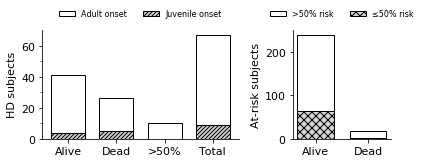

Button(button_style='info', description='Save SVG', style=ButtonStyle(), tooltip='Save to SVG file')

In [23]:
bars_file = "./data/JNNP_2020/Bar_plots.xlsx"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [2, 1]})


######## Panel A ########
dfA = pd.read_excel(bars_file, sheet_name="Figure A") #index_col=0, 
print(dfA)
print("")

labels = dfA.Patients
x = np.arange(len(labels))

adult_onset = dfA.iloc[:,1]
juvenile_onset = dfA.iloc[:,2]

width = 0.35*2  # the width of the bars
rects1 = ax1.bar(x, adult_onset, width, label='Adult onset', 
                 color='white', edgecolor='black')
rects2 = ax1.bar(x, juvenile_onset, width, label='Juvenile onset', 
                 color='lightgray', edgecolor='black', hatch="//////")

ax1.set_ylabel('HD subjects')
ax1.set_xticks(x)
ax1.set_yticks([10, 30, 50], minor=True)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=2, prop={"size":8}, frameon=False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

######## Panel B ########
dfB = pd.read_excel(bars_file, sheet_name="Figure B")
print(dfB)
print("")

labels = dfB.Patients
more50 = dfB.iloc[:,1]
less50 = dfB.iloc[:,2]

x = np.arange(len(labels))
width = 0.35*2

rects1 = ax2.bar(x, more50, width, label='>50% risk', 
                 color='white', edgecolor='black')
rects2 = ax2.bar(x, less50, width, label='≤50% risk', 
                 color='lightgray', edgecolor='black', hatch="xXX")

ax2.set_ylabel('At-risk subjects')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=2, prop={"size":8}, frameon=False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)


##### Plotting #####
fig.tight_layout()

plt.rcParams.update({'font.size': 10})
plt.show()


def on_save_misc_button(but):
    fig.savefig('misc_plots.svg', format='svg', dpi=1200)
    print('Figure saved')

save_misc_button = Button(
    description="Save SVG",
    button_style='info',
    tooltip='Save to SVG file'
)
save_misc_button.on_click(on_save_misc_button)
display(save_misc_button)

# Print system and required packages information

In [24]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,traitlets,IPython,ipywidgets

# date
print(" ")
%watermark -u -n -t -z

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
matplotlib 3.1.3
sklearn 0.22.1
traitlets 4.3.3
IPython 7.12.0
ipywidgets 7.5.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
 
last updated: Sun May 24 2020 12:30:06 W. Europe Summer Time
